# Network Layout

In [1]:
import warnings
from random import random
import copy
import math

import logging

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.optimize import minimize

import networkx as nx

warnings.filterwarnings('ignore')

#from layout import pushpull_layout, pathlength_layout

## PushPullLayout

In [248]:
def rescale_coords(pos, scale=1, center=0):
    node_list = pos.keys()
    # dict to array
    npos = np.row_stack((pos[x] for x in node_list))
    npos = npos.astype(np.float64)
    npos = nx.rescale_layout(npos, scale=scale) + center
    # array to dict
    return dict(zip(node_list, npos))

def init_pos(G):
    return dict(zip(G.nodes.keys(), np.random.rand(len(G.nodes), 2)))


def determine_domain(pos):
    """Determine the size of the domain.
    
    The domain size is the maximum value of a coordinate, 
    resp. the negative domain size the minimum value of a coordinate.
    Default domain size is 1. This result in a canvas of [-1, 1] in x and y direction. 
    
    :param pos: dict node to coordinates.
    :return: domain size
    """
    dom_size = max(abs(coord) for pos_tup in pos.values() for coord in pos_tup)
    if dom_size == 0:
        dom_size = 1
    return dom_size


def _weight(weight, edge):
    """Determine effective weight value."""
    if isinstance(weight, float) or isinstance(weight, int):
        return float(weight)
    if isinstance(weight, str) and weight in edge:
        return edge[weight]
    return 1.0


def _mass(mass, g_node):
    """Determine effective mass of node."""
    if isinstance(mass, float) or isinstance(mass, int):
        return float(mass)
    if isinstance(mass, str) and mass in g_node:
        return g_node[mass]
    return 1.0


def edge_pull(G, node, pos, weight):
    """Determine the offset introduced by edges on node.
    
    :param G: the graph.
    :param node: key of the node.
    :param pos: dictionary keys to positions.
    :param weight: edge attribute to consider as factor or None.
    
    :return: the replacement vector on node.
    """
    n_pos = pos[node].copy()
    p_off = np.zeros(2)
    num_neighbors = len(list(G.neighbors(node)))
    for kn in G.neighbors(node):
        weight = _weight(weight, G.edges[node, kn])
        v_diff = pos[kn] - pos[node]
        p_off += v_diff / ( num_neighbors * 1.0 * weight)
    n_pos += p_off
    return n_pos


def node_push(G, node, pos, mass):
    """Determine the offset vector introduced on node by other nodes.
    
    :param G: the graph
    :param node: key node
    :param pos: dictionary node keys to positions.
    :param mass: node attribute to consider as factor or None.

    :return: the offset vector.
    """
    domain = determine_domain(pos)
    epsilon = domain / 100.0
    n_pos = pos[node].copy()
    for kn in G.nodes():
        if kn != node: 
            m1 = _mass(mass, G[node])
            m2 = _mass(mass, G[kn])
            distance = np.linalg.norm(pos[node] - pos[kn])
            unit_vdir = (pos[node] - pos[kn]) / max(distance, epsilon)
            n_pos += unit_vdir / ((domain / 25 + distance) * 1.0 * m1 * m2)
    return n_pos


def _pushpull_layout(G, pos=None, iterations=10, mass='mass', weight='weight', diagnostics=False):
    pos_history = []
    if pos is None:
        pos_ = init_pos(G)
    else:
        pos_ = copy.deepcopy(pos)
    for _ in range(iterations):
        pos_next = {}
        for node in pos_.keys():
            pos_next[node] = node_push(G, node, pos_, mass)
        pos_ = rescale_coords(pos_next)
        #pos_ = pos_next
        for node in pos_.keys():
            pos_next[node] = edge_pull(G, node, pos_, weight)
        pos_ = rescale_coords(pos_next)
        if diagnostics:
            pos_history.append(pos_)
    return pos_, pos_history

## pathlength_layout

This layout engine tries to minimize the variance of the overall path length of a graph.

### Algorithm used for optimization

Compute the norm for the edges $E$ and calculate the variance $var_E$:

$$var_E = var(\{\, \lVert n_{e,0} - n_{e,1} \rVert\; :\; e \in E \,\})$$


For optimization we use `scipy.optimize.minimize`. `minimize` takes a function to optimize, a 1D array with the parameters to work on, and a tuple of optional parameters for the function. Our `pos` vectors are modeled as 2D array. Therefore we need to reshape to 1D array for `minimize` to work on, and reshape the result back after optimization. For calculations during optimization we need to determine the correct position in the 2D array for the coordinates of given nodes.

$$idx^{1D}_{x,i} = idx^{2D}_{i},\qquad idx^{1D}_{y,i} = idx^{1D}_{x,i} + 1$$


In [249]:
def minimize_path_length(pos_arr, edge_idx, method, tol):
    def variance_path_length(pos_arr, edge_idx):
        """Calculate variance of lengths of edges.
        
        Note: pos_arr is a 1D array, so the position of node coordinates must be calculated accordingly.
        
        :param pos_arr: 1D array of node coordinates x_0, y_0, x_1, y_1, ...
        :param edge_idx: list of edges described by indices into pos_arr.
        :return: variance edge lengths.
        """
        return np.var(np.asarray([ np.linalg.norm(np.asarray([pos_arr[i1], pos_arr[i1+1]]) - 
                                                  np.asarray([pos_arr[i2], pos_arr[i2+1]])) 
                                  for i1, i2 in edge_idx ]))


    fargs = (edge_idx, )
    ores = minimize(variance_path_length, pos_arr, fargs, method=method, tol=tol)
    if not ores.success:
        raise Exception(str(ores.message))
    return ores.x


def _pathlength_layout(G, pos=None, method='L-BFGS-B', tol=0.005, diagnostics=False):
    """Provide a layout with harmonized path lengths.
    
    :param G: graph to work on.
    :param pos: optional dictionary with pre-defined node positions.
    :param method: optimzation method to use (see scipy.optimize.minimize).
    :param tol: intensity of minimization, very small numbers will give edges of equal length.
    :param diagnostics: if True a history of node positions for each iteration is provided.
    """
    pos_history = []
    if pos is None:
        pos_ = init_pos(G)
    else:
        pos_ = copy.deepcopy(pos)
        
    # create map from node key to index into 2D array
    node_list = pos.keys()
    node_map = dict(zip(node_list, range(len(node_list))))
    # Pre-compute indices of edge nodes into pos_arr.
    edge_idx = [(node_map[n1] * 2, node_map[n2] * 2) for n1, n2 in G.edges]
    pos_arr = np.row_stack((pos[x] for x in node_list))
    pos_arr = pos_arr.astype(np.float64)

    pos_arr = minimize_path_length(pos_arr, edge_idx, method=method, tol=tol)
            
    # reshape back to 2D array ...
    npos = pos_arr.reshape(-1, 2)
    if diagnostics:
        pos_history.append(npos)
    # ... and return as pos dict
    return dict(zip(node_list, npos)), pos_history


### Define graph for test

In [250]:
G = nx.Graph()

G.add_edge('A', 'B', weight=2)
G.add_node('C')
G.add_node('D')
G.add_edge('A', 'E', weight=1)
G.add_edge('A', 'C', weight=1)
G.add_edge('A', 'D', weight=1)
G.add_edge('B', 'C', weight=1)
G.add_edge('C', 'D', weight=1)
G.add_edge('D', 'E', weight=1)
G.add_edge('E', 'B', weight=1)


#############

G = nx.karate_club_graph()

def set_weights(G):
    G.nodes()[29]['mass'] = 2
    G.nodes()[26]['mass'] = 2
    G.nodes()[30]['mass'] = 1

    G.nodes()[7]['mass'] = 1
    G.nodes()[3]['mass'] = 1


    G.edges()[0,11]['weight'] = 1
    G.edges()[32,33]['weight'] = 1
    G.edges()[33,32]['weight'] = 1
    
set_weights(G)


In [251]:
def total_path_length(G, pos):
    """Calculate the total path length of given graph and set of node podsitions."""
    return np.sum(np.asarray([ np.linalg.norm(pos[n1] - pos[n2]) for n1, n2 in G.edges ]))

def avg_path_length(G, pos):
    """Calculate average path length of given graph."""
    return np.mean(np.asarray([ np.linalg.norm(pos[n1] - pos[n2]) for n1, n2 in G.edges ]))

def min_path_length(G, pos):
    """Calculate minimum path length of given graph."""
    return np.min(np.asarray([ np.linalg.norm(pos[n1] - pos[n2]) for n1, n2 in G.edges ]))

def max_path_length(G, pos):
    """Calculate maximum path length of given graph."""
    return np.max(np.asarray([ np.linalg.norm(pos[n1] - pos[n2]) for n1, n2 in G.edges ]))

def path_length_variance(G, pos):
    """Calcullate the variance of the path lengths of the given graph."""
    return np.var(np.asarray([ np.linalg.norm(pos[n1] - pos[n2]) for n1, n2 in G.edges ]))

In [252]:
def plot_total_path_length_history(G, history):
    data = [total_path_length(G, x) for x in history]
    plt.figure(figsize=(12,4))
    plt.title("Total path length history")
    plt.plot(data)
    plt.grid(True)
    plt.ylabel('path length')
    plt.xlabel('iterations')

In [253]:
def plot_min_avg_max_path_length_history(G, history):
    min_data = [min_path_length(G, x) for x in history]
    avg_data = [avg_path_length(G, x) for x in history]
    max_data = [max_path_length(G, x) for x in history]
    plt.figure(figsize=(12,4))
    plt.title("Average path length history")
    plt.plot(min_data, label='minimum')
    plt.plot(avg_data, label='average')
    plt.plot(max_data, label='maximum')
    plt.grid(True)
    plt.ylabel('path length')
    plt.xlabel('iterations')
    plt.legend()

In [254]:
def plot_path_length_variance_history(G, history):
    data = [path_length_variance(G, x) for x in history]
    plt.figure(figsize=(12,4))
    plt.title("Variance of path length history")
    plt.plot(data)
    plt.grid(True)
    plt.ylabel('variance')
    plt.xlabel('iterations')

In [255]:
def plot_history(histories):
    """Plot historic movements of given nodes.
    
    :param histories: sequence of tuple ('node key', pos-history)
    """
    MAX_PLOTS = 4

    def plot_node_histories(hists):

        def key(idx):
            return hists[idx][0]

        def data(idx):
            return hists[idx][1]

        def scatter_x(idx):
            return [d[0] for d in data(idx)]

        def scatter_y(idx):
            return [d[1] for d in data(idx)]

        num_datasets = len(hists)
        subplot_base = 200 + 10 * num_datasets

        plt.figure(figsize=(12,6))

        for dataset in range(num_datasets):
            idx = dataset + 1  # first row index
            if idx == 1:
                ax1 = plt.subplot(subplot_base + idx)
                plt.ylabel('domain y')
            else:
                plt.subplot(subplot_base + idx, sharex=ax1, sharey=ax1)
            plt.title(key(dataset))
            plt.scatter(scatter_x(dataset), y=scatter_y(dataset))
            plt.grid(True)
            plt.xlabel('domain x')
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)

            idx2 = idx + num_datasets  # second row index
            if idx == 1:
                ax2 = plt.subplot(subplot_base + idx2)
                plt.ylabel('domain')
            else:
                plt.subplot(subplot_base + idx2, sharex=ax2, sharey=ax2)
            plt.plot(data(dataset))
            plt.grid(True)
            plt.xlabel('iteration')
            plt.ylim(-1.1, 1.1)

        plt.tight_layout()

    while histories:
        plot_node_histories(histories[:MAX_PLOTS])
        histories = histories[MAX_PLOTS:]


def prepare_hist(diags, keys):
    """Prepare historical data of given nodes for presentation.
    
    :param diags: historical node positions as provided by `pushpull_layout`.
    :param keys: list of keys to plot historical data for.
    
    :return: list of tuples (key, position-history)
    """
    return [ (str(key), [positions[key] for positions in diags]) for key in keys ]

def prepare_all_hist(diags):
    """Prepare historical data of all nodes for presentation.
    
    :param diags: historical node positions as provided by `pushpull_layout`.
    
    :return: list of tuples (key, position-history)
    """
    return [ (str(key), [positions[key] for positions in diags]) for key in diags[0].keys() ]

In [256]:
def plot_diagnostics(G, history, full=False):
    plot_total_path_length_history(G, history)
    plot_min_avg_max_path_length_history(G, history)
    plot_path_length_variance_history(G, history)
    if full:
        plot_history(prepare_all_hist(history))

In [257]:
#%%timeit
#init_pos(G)
#rescale_coords(pos)
#_pushpull_layout(G, pos=None, iterations=50, mass='mass', weight='weight', diagnostics=False)
#_pathlength_layout(G, pos=None, tol=0.005, diagnostics=False)



### Layout and draw graph

CPU times: user 2.29 s, sys: 21.2 ms, total: 2.31 s
Wall time: 2.31 s


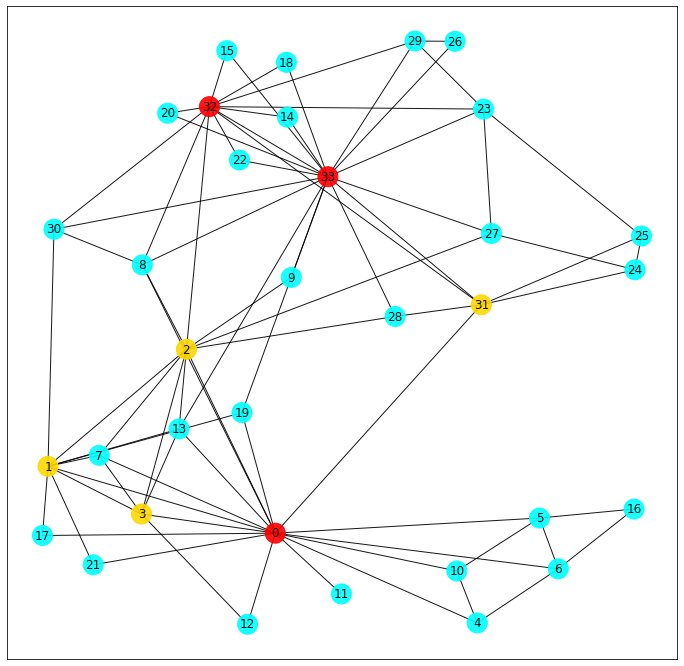

In [258]:
%%time

def colors(G):
    colors_ = []
    for n in G.nodes():
        d = nx.degree(G, n)
        if d > 10:
            colors_.append('r')
        elif d > 5:
            colors_.append('gold')
        else:
            colors_.append('aqua')
    return colors_

post_process=False
pos = None
pos, diags = _pushpull_layout(G, pos=pos, iterations=75, mass=2.4, weight=1.4, diagnostics=True)
#pos, diags = _pushpull_layout(G, pos=pos, iterations=75, mass=3.0, weight=2.7, diagnostics=True)

if post_process:
    for run in range(5):
        pos, diags_ = _pathlength_layout(G, pos=pos, tol=0.05 / (run+1), diagnostics=True)
        diags.extend(diags_)
        pos, diags_ = _pushpull_layout(G, pos=pos, iterations=5, mass=2.0, weight=1.4, diagnostics=True)
        diags.extend(diags_)
    pos, diags_ = _pathlength_layout(G, pos=pos, tol=0.05, diagnostics=True)
    diags.extend(diags_)


plt.figure(figsize=(12, 12))
nx.draw_networkx(G, pos=pos, node_color=colors(G), node_size=400, alpha=0.9)

### Plot diagnostic data

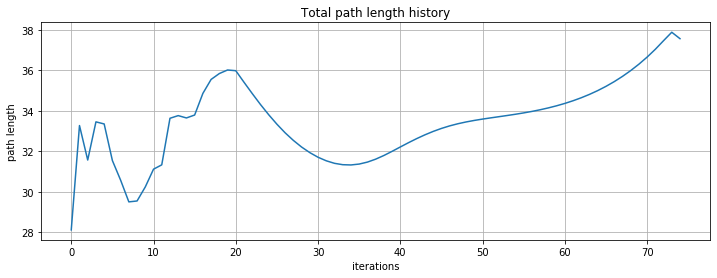

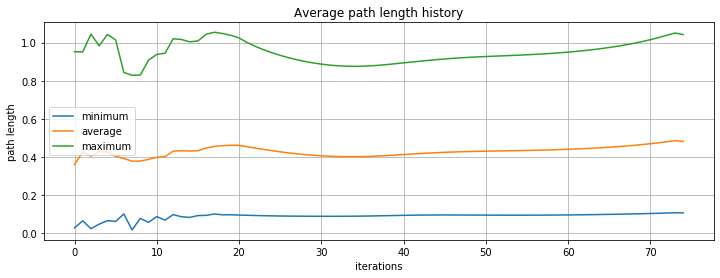

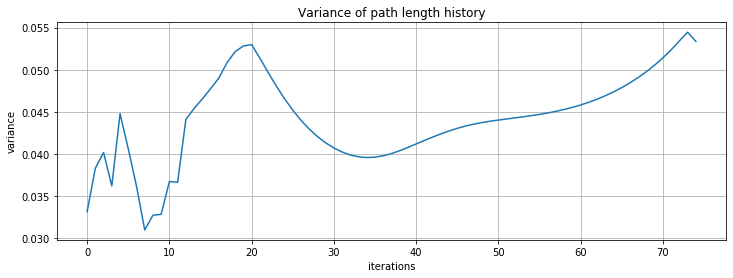

In [259]:
plot_diagnostics(G, diags, full=False)

## Various Graph Types and Sizes

In [260]:
#def layout_graph(G, iterations=75, post_process=False, mass=2.0, weight=0.4, diagnostics=False):

def layout_graph(G, iterations=75, post_process=False, mass=1.0, weight=1.0, diagnostics=False):

    pos, diags = _pushpull_layout(G, pos=None, iterations=iterations, mass=mass, weight=weight, diagnostics=diagnostics)
    if post_process:
        for run in range(5):
            pos, diags_ = _pathlength_layout(G, pos=pos, tol=0.05 / (run+1), diagnostics=diagnostics)
            diags.extend(diags_)
            pos, diags_ = _pushpull_layout(G, pos=pos, iterations=5, mass=2.0, weight=2.0, diagnostics=diagnostics)
            diags.extend(diags_)
        pos, diags_ = _pathlength_layout(G, pos=pos, tol=0.05, diagnostics=diagnostics)
        diags.extend(diags_)
    return pos, diags

def draw_graph(G, pos):
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos=pos, node_size=400, alpha=0.9)
    nx.draw_networkx_edges(G, pos=pos, node_size=400, alpha=0.4)
    nx.draw_networkx_labels(G, pos=pos, font_size=9, alpha=0.9)

def layout_and_draw_graph(G, diagnostics=False, full_diagnostics=False):
    pos, diags = layout_graph(G, post_process=True, diagnostics=diagnostics)
    draw_graph(G, pos)
    if diagnostics:
        plot_diagnostics(G, diags, full=full_diagnostics)


### Balanced Tree

CPU times: user 11.3 s, sys: 218 ms, total: 11.6 s
Wall time: 11.4 s


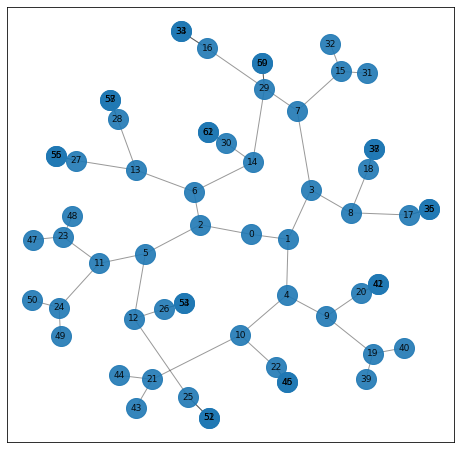

In [261]:
%%time
def balanced_tree():
    G = nx.balanced_tree(2, 5)
    layout_and_draw_graph(G)
    
balanced_tree()

### Complete Graph

CPU times: user 724 ms, sys: 5.49 ms, total: 729 ms
Wall time: 770 ms


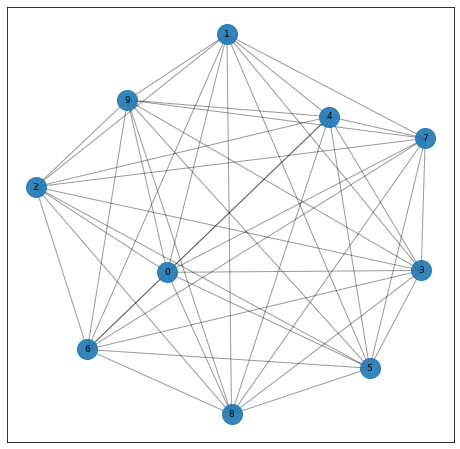

In [262]:
%%time
def complete_graph(n):
    G = nx.complete_graph(n)
    layout_and_draw_graph(G)

complete_graph(10)

CPU times: user 1.78 s, sys: 15.8 ms, total: 1.79 s
Wall time: 1.8 s


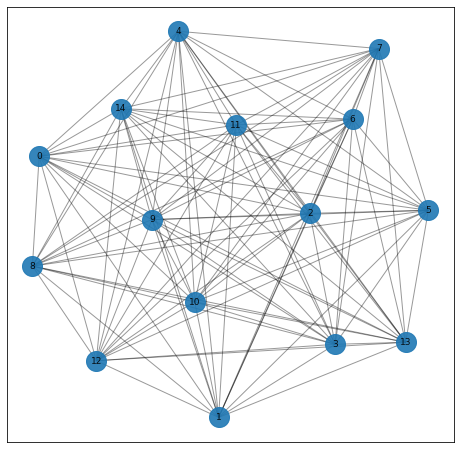

In [263]:
%%time
complete_graph(15)

### Ladder Graph

CPU times: user 4.44 s, sys: 49.1 ms, total: 4.49 s
Wall time: 4.47 s


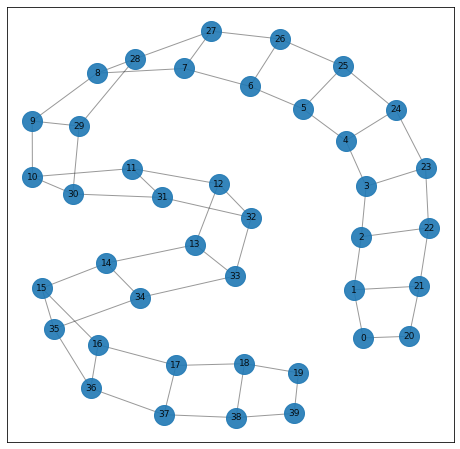

In [264]:
%%time
def ladder_graph():
    G = nx.ladder_graph(20)
    layout_and_draw_graph(G)

ladder_graph()

### Dorogovtsev Goltsev Mendes Graph

CPU times: user 209 ms, sys: 40.5 ms, total: 250 ms
Wall time: 217 ms


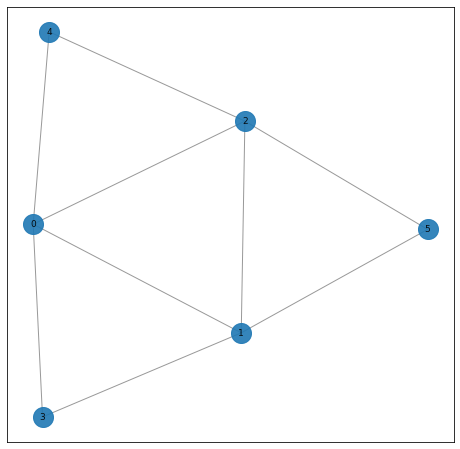

In [265]:
%%time
def dorogovtsev_goltsev_mendes_graph(n):
    G = nx.dorogovtsev_goltsev_mendes_graph(n)
    layout_and_draw_graph(G)

dorogovtsev_goltsev_mendes_graph(2)

CPU times: user 880 ms, sys: 15 ms, total: 895 ms
Wall time: 890 ms


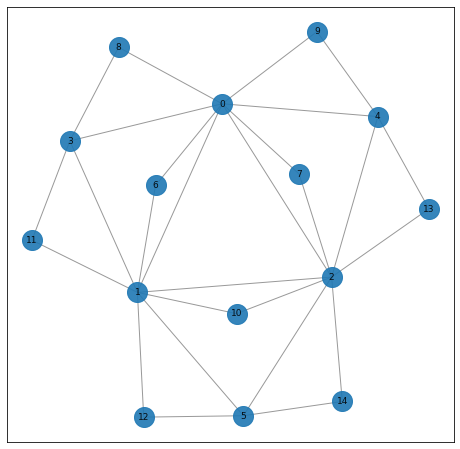

In [266]:
%%time
dorogovtsev_goltsev_mendes_graph(3)

### Grid 2D Graph

CPU times: user 213 ms, sys: 11.6 ms, total: 224 ms
Wall time: 220 ms


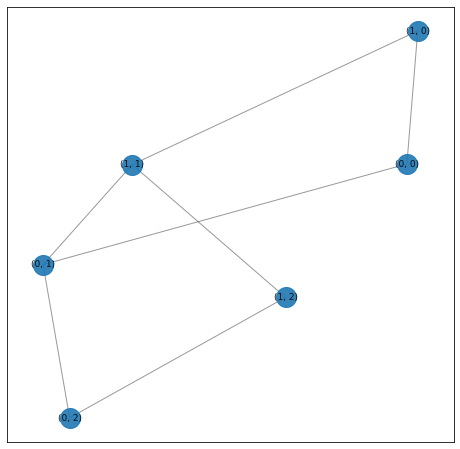

In [267]:
%%time
def grid_2d_graph(n, m):
    G = nx.grid_2d_graph(n, m)
    layout_and_draw_graph(G)

grid_2d_graph(2, 3)

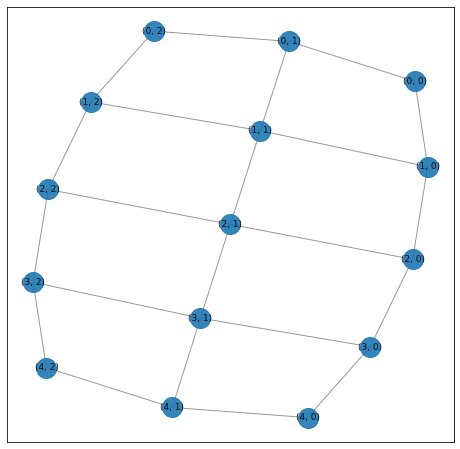

In [268]:
grid_2d_graph(5, 3)

### Grid 4D Graph

CPU times: user 1.05 s, sys: 18.9 ms, total: 1.07 s
Wall time: 1.07 s


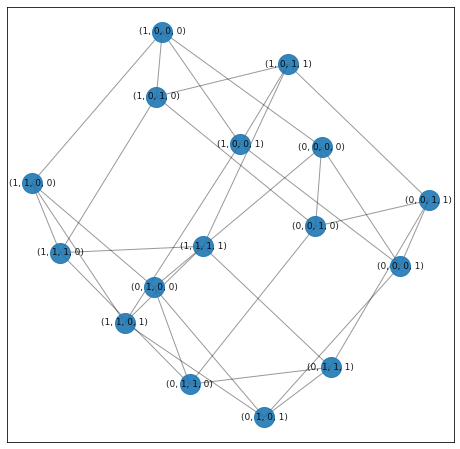

In [269]:
%%time
def grid_graph(n, m, o, p):
    G = nx.grid_graph( dim=[n, m, o, p] )
    layout_and_draw_graph(G)

grid_graph(2, 2, 2, 2)

CPU times: user 2.13 s, sys: 25.4 ms, total: 2.15 s
Wall time: 2.16 s


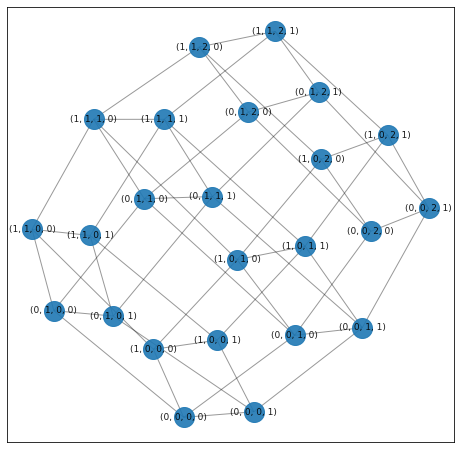

In [270]:
%%time
grid_graph(2, 3, 2, 2)

### Florentine Families Graph

CPU times: user 888 ms, sys: 9.12 ms, total: 897 ms
Wall time: 895 ms


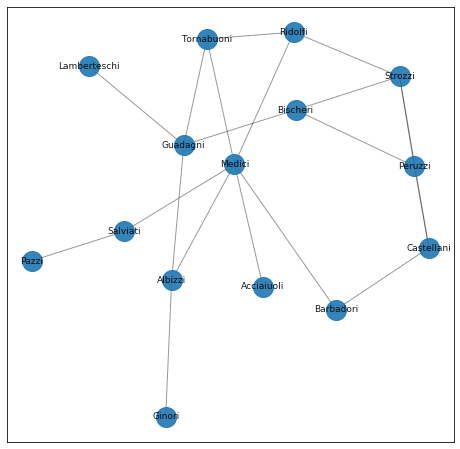

In [271]:
%%time
def florentine_families_graph():
    G = nx.florentine_families_graph()
    layout_and_draw_graph(G)

florentine_families_graph()

### Ring of Cliques Graph

CPU times: user 965 ms, sys: 20.8 ms, total: 985 ms
Wall time: 980 ms


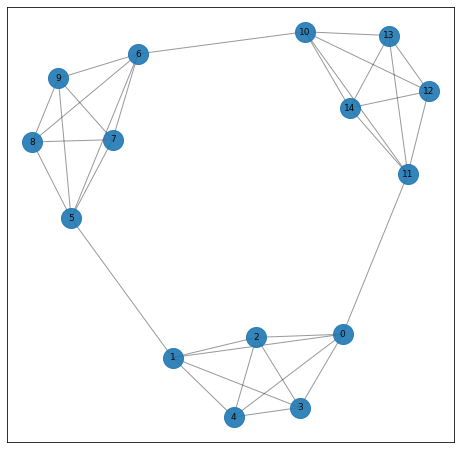

In [272]:
%%time
def ring_of_cliques_graph():
    G = nx.ring_of_cliques(3, 5)
    layout_and_draw_graph(G)
    
ring_of_cliques_graph()

### Caveman Graph

CPU times: user 2.58 s, sys: 40 ms, total: 2.62 s
Wall time: 2.6 s


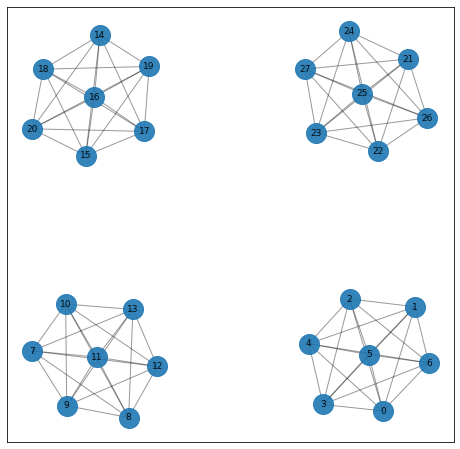

In [273]:
%%time
def caveman_graph():
    G = nx.caveman_graph(4, 7)
    layout_and_draw_graph(G)
    
caveman_graph()